# Bank Client Segmentation (K-Means)
This notebook builds an unsupervised **customer segmentation** using **K-Means**.

**Pipeline:** Data load → Cleaning → Scaling → Choose *K* → Fit K-Means → Cluster profiling → Visualization → Export.

> **Note:** update `DATA_PATH` to where your dataset is stored.

In [21]:
# 0.0 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# 0.1 Reproducibility & config
RANDOM_STATE = 42

# TODO: Update this path to your environment
DATA_PATH = "/content/drive/MyDrive/Data Science/client segmentation/dados_clientes.csv"

# K search space (start at 2 because silhouette is undefined for K=1)
K_MIN, K_MAX = 2, 20


# 1.0 Data Load

In [23]:
df_raw = pd.read_csv(DATA_PATH)
df_raw.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [24]:
# Basic sanity checks
print("Shape:", df_raw.shape)
display(df_raw.info())
df_raw.isna().mean().sort_values(ascending=False).head(10)

Shape: (8950, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   i

None

,0
MINIMUM_PAYMENTS,0.034972
CREDIT_LIMIT,0.000112
BALANCE,0.000000
CUST_ID,0.000000
BALANCE_FREQUENCY,0.000000
PURCHASES,0.000000
CASH_ADVANCE,0.000000
PURCHASES_FREQUENCY,0.000000
ONEOFF_PURCHASES,0.000000
INSTALLMENTS_PURCHASES,0.000000


In [25]:
# Keep customer id for export (if present)
ID_COL = "CUST_ID"
if ID_COL in df_raw.columns:
    customer_id = df_raw[ID_COL].copy()
    df = df_raw.drop(columns=[ID_COL]).copy()
else:
    customer_id = None
    df = df_raw.copy()

# Ensure numeric-only (K-Means requires numeric features)
# If your dataset has categoricals, handle them before this step (e.g., one-hot).
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    raise ValueError(f"Non-numeric columns found: {non_numeric}. Encode them before K-Means.")


# 2.0 Cleaning & Pre-processing
We avoid dropping rows aggressively. For this dataset, we apply **median imputation** per feature.
Then we scale features using **StandardScaler** (critical for distance-based clustering).

In [26]:
# 2.1 Missing values: median imputation (simple and robust baseline)
missing_pct = df.isna().mean().sort_values(ascending=False)
print("Top missing columns (pct):")
display(missing_pct.head(10))

df_imputed = df.copy()
for col in df_imputed.columns:
    if df_imputed[col].isna().any():
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

# Confirm no missing
assert df_imputed.isna().sum().sum() == 0
df_imputed.shape


Top missing columns (pct):


,0
MINIMUM_PAYMENTS,0.034972
CREDIT_LIMIT,0.000112
BALANCE,0.000000
BALANCE_FREQUENCY,0.000000
PURCHASES,0.000000
CASH_ADVANCE,0.000000
PURCHASES_FREQUENCY,0.000000
ONEOFF_PURCHASES,0.000000
INSTALLMENTS_PURCHASES,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,0.000000


(8950, 17)

In [27]:
# 2.2 Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df_imputed)

print("Scaled matrix shape:", X.shape)


Scaled matrix shape: (8950, 17)


# 3.0 Choosing the number of clusters (K)
We combine multiple internal metrics:
- **Inertia (WCSS)**: lower is better (use elbow)
- **Silhouette**: higher is better
- **Davies–Bouldin**: lower is better
- **Calinski–Harabasz**: higher is better


In [28]:
def evaluate_kmeans_k(X, k_values, random_state=42):
    rows = []
    for k in k_values:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)

        rows.append({
            "k": k,
            "inertia": km.inertia_,
            "silhouette": silhouette_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
        })
    return pd.DataFrame(rows).sort_values("k")

k_values = list(range(K_MIN, K_MAX + 1))
df_k = evaluate_kmeans_k(X, k_values, random_state=RANDOM_STATE)
df_k


,k,inertia,silhouette,davies_bouldin,calinski_harabasz
0,2,127784.534545,0.210043,1.911979,1706.178957
1,3,111975.043593,0.250988,1.591959,1605.026358
2,4,99061.939842,0.197679,1.574837,1598.076876
3,5,91490.498040,0.193112,1.549204,1482.668187
4,6,84826.592031,0.202860,1.506422,1419.699364
5,7,79856.157018,0.207686,1.491776,1349.350845
6,8,74484.880062,0.221698,1.369689,1331.973443
7,9,69828.699269,0.226034,1.294268,1317.572228
8,10,66466.414929,0.220438,1.363093,1280.531848
9,11,63615.001383,0.216303,1.328967,1244.074967


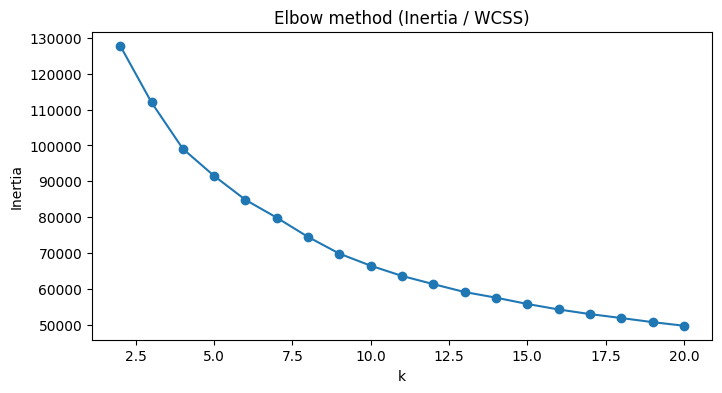

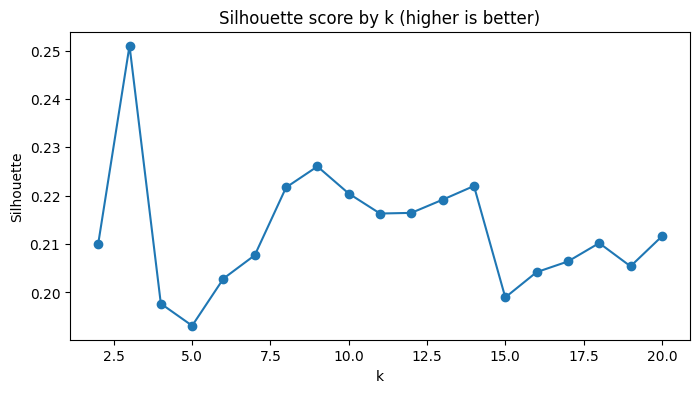

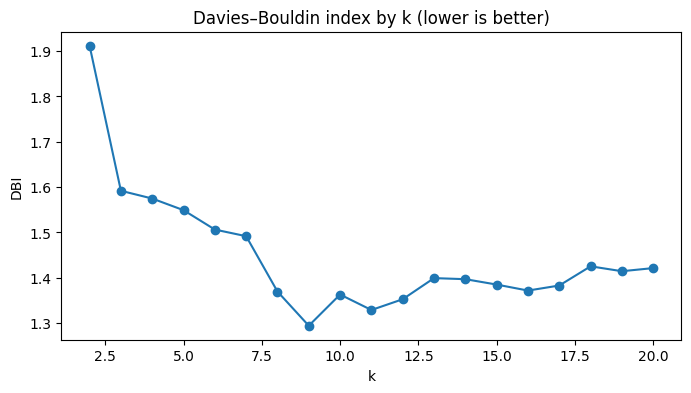

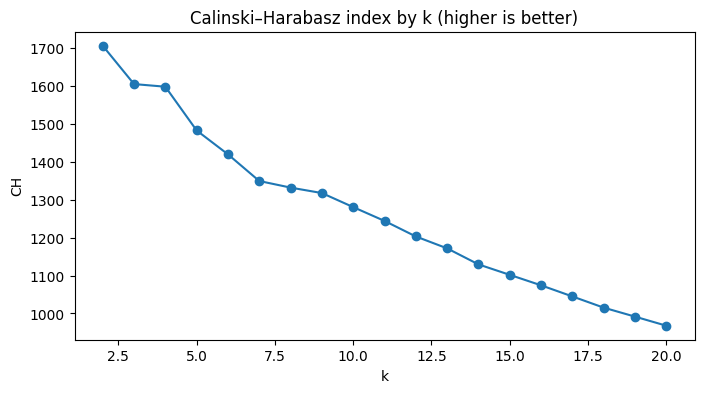

In [29]:
# Visualize metrics
plt.figure(figsize=(8, 4))
plt.plot(df_k["k"], df_k["inertia"], marker="o")
plt.title("Elbow method (Inertia / WCSS)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_k["k"], df_k["silhouette"], marker="o")
plt.title("Silhouette score by k (higher is better)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_k["k"], df_k["davies_bouldin"], marker="o")
plt.title("Davies–Bouldin index by k (lower is better)")
plt.xlabel("k")
plt.ylabel("DBI")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_k["k"], df_k["calinski_harabasz"], marker="o")
plt.title("Calinski–Harabasz index by k (higher is better)")
plt.xlabel("k")
plt.ylabel("CH")
plt.show()


In [30]:
# Suggested K:
# - choose the k with the best silhouette as a strong baseline
k_best = int(df_k.loc[df_k["silhouette"].idxmax(), "k"])
k_best


3

# 4.0 Fit final K-Means model

In [31]:
# You can override k_best if business interpretability suggests another k
K_FINAL = 8

kmeans = KMeans(n_clusters=K_FINAL, n_init=10, random_state=RANDOM_STATE)
cluster = kmeans.fit_predict(X)

# Attach to original (imputed) features for interpretation
df_clustered = df_imputed.copy()
df_clustered["cluster"] = cluster

if customer_id is not None:
    df_clustered.insert(0, ID_COL, customer_id.values)

df_clustered.head()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,1
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


# 5.0 Cluster profiling
Goal: make clusters **actionable**.

We compute:
- cluster sizes
- feature means/medians by cluster
- centroids (in original scale)
- top differentiating features (z-score vs overall)


In [32]:
# 5.1 Cluster size distribution
cluster_counts = df_clustered["cluster"].value_counts().sort_index()
cluster_pct = (cluster_counts / len(df_clustered) * 100).round(2)

summary_sizes = pd.DataFrame({"count": cluster_counts, "pct": cluster_pct})
summary_sizes


,count,pct
cluster,,
0,897,10.02
1,2740,30.61
2,2005,22.40
3,1116,12.47
4,1179,13.17
5,364,4.07
6,624,6.97
7,25,0.28


In [33]:
# 5.2 Centroids (back to original scale for interpretability)
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

df_centroids = pd.DataFrame(centroids, columns=df_imputed.columns)
df_centroids.insert(0, "cluster", range(K_FINAL))
df_centroids


,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0,5019.379833,0.971163,519.896656,323.055511,196.954111,5117.161747,0.294084,0.138096,0.194927,0.515092,16.162222,7.840000,8184.116162,3994.201755,2051.721748,0.037872,11.621111
1,1,1572.058107,0.972641,243.330241,193.481392,50.029660,753.221871,0.150076,0.085440,0.065894,0.152225,2.970040,2.779320,3365.004263,995.699376,823.488678,0.020269,11.883449
2,2,801.869204,0.955825,927.742918,190.138499,738.049945,216.437430,0.890091,0.088044,0.844789,0.040395,0.792020,19.440399,3548.114814,1109.143357,739.473549,0.246827,11.859352
3,3,1259.471048,0.971939,2157.982204,1705.726129,452.256075,282.819551,0.884225,0.771701,0.431311,0.052133,0.979391,30.046595,6028.608667,2146.657154,481.477268,0.286100,11.877240
4,4,104.088618,0.368606,339.884300,202.217863,137.918176,308.802244,0.267350,0.069984,0.189781,0.030944,0.682782,4.283291,3857.667044,1176.492301,181.455267,0.237544,11.784563
5,5,3762.436640,0.988237,6199.766676,3533.304973,2668.110055,669.916456,0.959341,0.660427,0.872985,0.080561,2.266484,91.164835,9133.241758,5862.758729,2567.001967,0.223396,11.969780
6,6,869.441195,0.795307,387.463654,236.537740,151.406683,1120.452630,0.408737,0.116973,0.274915,0.196992,3.254808,5.068910,2443.141026,596.186218,341.561325,0.157627,7.233974
7,7,5351.546106,0.948727,27085.309200,21002.018800,6083.290400,1488.363253,0.892667,0.808667,0.708667,0.056667,2.400000,123.320000,16360.000000,27159.043527,3201.825604,0.490758,11.920000


In [34]:
# 5.3 Mean/Median profile tables
feature_cols = [c for c in df_clustered.columns if c not in [ID_COL, "cluster"]]

profile_mean = df_clustered.groupby("cluster")[feature_cols].mean().round(3)
profile_median = df_clustered.groupby("cluster")[feature_cols].median().round(3)

display(profile_mean.head())
display(profile_median.head())


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,5017.366,0.971,521.560,324.060,197.613,5125.215,0.295,0.138,0.196,0.516,16.196,7.865,8187.519,4003.342,2053.250,0.038,11.620
1,1576.492,0.973,243.089,193.294,49.975,755.363,0.150,0.085,0.066,0.152,2.973,2.777,3369.167,995.990,824.333,0.020,11.884
2,801.869,0.956,927.743,190.138,738.050,216.437,0.890,0.088,0.845,0.040,0.792,19.440,3548.115,1109.143,739.474,0.247,11.859
3,1259.471,0.972,2157.982,1705.726,452.256,282.820,0.884,0.772,0.431,0.052,0.979,30.047,6028.609,2146.657,481.477,0.286,11.877
4,104.089,0.369,339.884,202.218,137.918,308.802,0.267,0.070,0.190,0.031,0.683,4.283,3857.667,1176.492,181.455,0.238,11.785


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,4804.072,1.000,107.330,0.000,0.00,4195.105,0.083,0.000,0.000,0.500,13.0,1.0,8000.0,2249.612,1439.231,0.000,12.0
1,1250.640,1.000,45.745,0.000,0.00,290.171,0.083,0.000,0.000,0.083,2.0,1.0,2500.0,634.784,434.249,0.000,12.0
2,287.884,1.000,666.600,0.000,534.00,0.000,1.000,0.000,0.917,0.000,0.0,14.0,2500.0,772.321,193.758,0.000,12.0
3,624.972,1.000,1912.600,1371.265,248.53,0.000,1.000,0.818,0.417,0.000,0.0,26.0,6000.0,1721.491,232.738,0.083,12.0
4,23.651,0.364,167.220,0.000,23.33,0.000,0.182,0.000,0.083,0.000,0.0,3.0,3000.0,415.604,135.799,0.000,12.0


In [35]:
# 5.4 Top differentiating features per cluster (z-score of centroid vs overall mean/std)
overall_mean = df_imputed[feature_cols].mean()
overall_std = df_imputed[feature_cols].std().replace(0, np.nan)

z = (df_centroids[feature_cols] - overall_mean) / overall_std
z.index = df_centroids["cluster"]

top_features = {}
for cl in z.index:
    top_features[cl] = z.loc[cl].abs().sort_values(ascending=False).head(8)

# Display as a readable table
top_df = pd.DataFrame({f"cluster_{cl}": top_features[cl] for cl in top_features})
top_df


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
BALANCE,1.659790,NaN,0.366367,NaN,0.701592,NaN,0.333905,1.819367
BALANCE_FREQUENCY,NaN,0.402569,NaN,NaN,2.147133,NaN,0.345977,NaN
CASH_ADVANCE,1.973280,NaN,0.363555,NaN,NaN,NaN,NaN,NaN
CASH_ADVANCE_FREQUENCY,1.898585,NaN,0.473460,0.414803,0.520684,NaN,0.309051,NaN
CASH_ADVANCE_TRX,1.892171,NaN,0.359990,NaN,0.375997,NaN,NaN,NaN
CREDIT_LIMIT,1.014068,NaN,NaN,0.421675,NaN,1.274913,0.563710,3.261025
INSTALLMENTS_PURCHASES,NaN,0.399229,0.361571,NaN,NaN,2.495795,NaN,6.272237
MINIMUM_PAYMENTS,0.517326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ONEOFF_PURCHASES,NaN,NaN,NaN,0.670701,NaN,1.771727,NaN,12.295759
ONEOFF_PURCHASES_FREQUENCY,NaN,0.392234,0.383507,1.908060,0.444042,1.535079,NaN,2.031967


# 6.0 Visualization (PCA 2D)
PCA here is used **only for visualization**. The clustering was trained on the full scaled space.

/tmp/ipython-input-594447916.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


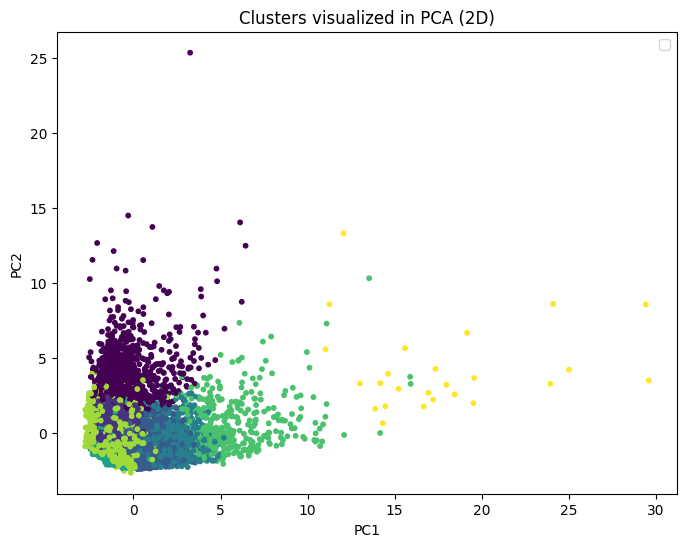

Explained variance (PC1+PC2): 0.4761


In [38]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster, s=10)
plt.title("Clusters visualized in PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

print("Explained variance (PC1+PC2):", pca.explained_variance_ratio_.sum().round(4))


# 7.0 Export
Exports a dataset with the assigned cluster per customer.

In [37]:
OUTPUT_PATH = "bank_clients_with_clusters.csv"
df_clustered.to_csv(OUTPUT_PATH, index=False)
print("Saved:", OUTPUT_PATH)


Saved: bank_clients_with_clusters.csv


# 8.0 Business

# Business Application — How Customer Segmentation Generates Revenue (8 Clusters)

## Objective
This segmentation model groups **8,950 credit card customers** into **8 behavioral clusters** using **K-Means**, based on:
- spending behavior (`PURCHASES`, `ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`)
- cash advance behavior (`CASH_ADVANCE`, `CASH_ADVANCE_TRX`, `CASH_ADVANCE_FREQUENCY`)
- payment profile (`PAYMENTS`, `MINIMUM_PAYMENTS`, `PRC_FULL_PAYMENT`)
- credit capacity (`CREDIT_LIMIT`)
- account maturity (`TENURE`)
- balance dynamics (`BALANCE`, `BALANCE_FREQUENCY`)

The main goal is to transform these clusters into **targeted business strategies** that increase **profit**, reduce **risk**, lower **operational costs**, and improve **customer lifetime value (LTV)**.

---

## Cluster Summary (Profile + Monetization Opportunity)

### Cluster 7 — Ultra Premium / Big Spenders *(~25 customers)*
**Typical behavior**
- Extremely high `PURCHASES`
- Very high `CREDIT_LIMIT`
- Strong payment behavior

**How to monetize**
- Premium card upgrade (annual fee / premium packages)
- Travel insurance, purchase protection, premium services
- Investment cross-sell (high-ticket customers)

**Business focus:** maximize margin per customer (high value, low scale)

---

### Cluster 5 — Premium High Usage *(~364 customers)*
**Typical behavior**
- Very high `PURCHASES`
- High `CREDIT_LIMIT`
- High `PAYMENTS`

**How to monetize**
- Increase card spend via partner offers (interchange revenue)
- Premium services and insurance bundles
- Smart credit limit increases to unlock additional spend

**Business focus:** direct revenue growth from high usage behavior

---

### Cluster 3 — High Consumption + High Credit Limit *(~1,116 customers)*
**Typical behavior**
- High `PURCHASES`
- High `CREDIT_LIMIT`
- Strong engagement and frequency

**How to monetize**
- Installments and BNPL-style offers to increase ticket size
- Cross-sell: insurance, investments, loyalty products
- Retention programs (reduce churn among valuable clients)

**Business focus:** grow spend and retain high-potential customers

---

### Cluster 2 — Heavy Users / High Engagement *(~2,005 customers)*
**Typical behavior**
- High `PURCHASES_FREQUENCY`
- Consistent usage across the month
- Moderate payment profile

**How to monetize**
- Increase average ticket (cashback tiers, category-based rewards)
- Subscription / loyalty offers to increase retention
- Improve payments and reduce revolving risk (healthy credit usage)

**Business focus:** scale revenue through engagement at volume

---

### Cluster 1 — Low Spend + Low Full Payment *(~2,740 customers)*
**Typical behavior**
- Low `PURCHASES`
- Very low `PRC_FULL_PAYMENT`
- Large segment with mixed potential (may include risk + disengaged users)

**How to monetize**
- Re-activation campaigns (first-purchase incentive)
- Controlled credit offers (avoid aggressive limit increases)
- Financial education nudges to improve payments

**Business focus:** convert volume into growth while protecting risk

---

### Cluster 0 — Cash Advance Dependents / High Risk *(~897 customers)*
**Typical behavior**
- Very high `CASH_ADVANCE`
- High cash advance frequency and transactions
- High `BALANCE` and low full payment

**How to monetize (and reduce losses)**
- Replace cash advance with personal loan (healthier + less risky)
- Early intervention and renegotiation offers
- Risk-based credit policies (limits, alerts, prevention rules)

**Business focus:** reduce default losses and improve portfolio health

---

### Cluster 6 — Mid Risk / Moderate Cash Advance *(~624 customers)*
**Typical behavior**
- Lower credit limit
- Moderate cash advance usage
- Moderate payments and tenure

**How to monetize**
- Controlled credit offers and installment-based products
- Payment improvement programs (reduce minimum-payment behavior)
- Retention through simple benefit structures

**Business focus:** prevent risk migration and stabilize profit

---

### Cluster 4 — Low Balance + Light Usage *(~1,179 customers)*
**Typical behavior**
- Low `BALANCE`
- Medium/low spending and light engagement

**How to monetize**
- Activate daily card usage (cashback for essential categories)
- Partner discounts (drive frequency)
- Simple in-app campaigns to increase transactions

**Business focus:** increase engagement and transaction frequency

---

## Monetization Strategies (Practical Playbook)

### Strategy 1 — Revenue Growth (Cross-sell + Upsell + Interchange)
**Target clusters:** 7, 5, 3, 2  
**Goal:** increase purchase volume and product adoption

**Actions**
- Premium card upgrades and loyalty plans
- Partner cashback campaigns (travel, e-commerce, restaurants)
- Safe credit limit increases for high-value clusters
- Add-on products: insurance, investment accounts

**Main KPIs**
- Purchase volume (`PURCHASES`)
- Transaction count (`PURCHASES_TRX`)
- Conversion rate per offer
- Retention rate

---

### Strategy 2 — Risk Reduction (Lower Losses + Protect Margin)
**Target clusters:** 0, 1, 6  
**Goal:** reduce cash advance dependency and prevent delinquency

**Actions**
- Replace cash advance with structured loan products
- Early warning and renegotiation flows
- Credit risk policies by cluster (limit and monitoring rules)
- Payment nudges to increase full payment ratio

**Main KPIs**
- Reduction in `CASH_ADVANCE` / `CASH_ADVANCE_TRX`
- Increase in `PAYMENTS`
- Improvement in `PRC_FULL_PAYMENT`
- Reduction in default/loss metrics (if available)

---

### Strategy 3 — Engagement & Re-activation (Low Usage Customers)
**Target clusters:** 4 and part of 1  
**Goal:** turn inactive/low usage customers into active spenders

**Actions**
- First-purchase incentives
- Low-friction cashback promotions
- In-app education and category-based offers
- Loyalty points for consistent use

**Main KPIs**
- Purchase frequency (`PURCHASES_FREQUENCY`)
- Re-activation rate
- Increase in `PURCHASES_TRX`

---

## Business Value Estimation (Profit, Revenue, and Cost Reduction)
The segmentation itself does not generate value until it is deployed into **campaigns, pricing, credit policies, and CRM actions**.  
Below are realistic **impact scenarios** for a portfolio of **8,950 customers**.

> **Note:** The values below are estimates using common banking assumptions.  
> The final ROI must be validated through **A/B tests** and financial tracking.

---

### 1) Profit Increase from Higher Card Spend (Interchange Revenue)
**Target clusters:** 7, 5, 3, 2 *(~3,510 customers)*  
Assumption:
- We run a growth campaign on these customers
- **10% conversion rate** (customers who increase usage)
- Average spend increase: **+$30/month** per converted customer
- Interchange margin: **~1.0%** of spend (conservative)

**Estimated annual revenue uplift**
- Converted customers: `3,510 × 10% = 351`
- Extra spend/year: `351 × $30 × 12 = $126,360`
- Interchange profit/year: `1.0% × $126,360 ≈ $1,264`

✅ **Takeaway:** Interchange alone is not the biggest profit driver at this scale.  
The real upside comes when spend growth is combined with **fees + lending products**.

---

### 2) Profit Increase from Premium Upgrades (Annual Fees)
**Target clusters:** 7 and 5 *(~389 customers)*  
Assumption:
- Upgrade conversion: **5%**
- Annual fee: **$120/year**

**Estimated annual incremental revenue**
- Converted: `389 × 5% ≈ 19 customers`
- Revenue: `19 × $120 = $2,280/year`

✅ This grows significantly when the base scales to hundreds of thousands of customers.

---

### 3) Lending Profit: Replace Cash Advance with Personal Loan
**Target cluster:** 0 *(~897 customers)*  
Cash advance behavior is often associated with:
- higher default risk
- worse customer experience (high fees)
- unstable repayment profile

Assumption:
- **15%** of these customers accept conversion to a structured loan
- Loan profit contribution: **$150/year** per customer (net)

**Estimated annual profit**
- Converted: `897 × 15% = 135 customers`
- Profit: `135 × $150 = $20,250/year`

✅ This strategy generates **real profit** and improves portfolio health.

---

### 4) Cost Reduction from Risk Control (Loss Prevention)
**Target clusters:** 0, 1, 6 *(~4,261 customers)*  
Assumption:
- Early intervention prevents losses for a portion of customers
- Loss prevention benefit: **$50/year** per at-risk customer (conservative)

**Estimated annual cost reduction**
- Benefit: `4,261 × $50 = $213,050/year`

✅ This is typically the **largest monetary impact** in credit portfolios.

---

### 5) Operational Cost Reduction (Better Targeting = Less Waste)
Segmentation enables banks to reduce the campaign footprint:
- fewer outbound calls
- less SMS/email volume
- fewer incentives wasted on low-propensity groups

Assumption:
- we avoid targeting **30%** of low-probability customers
- saved cost per customer targeted (CRM + incentive): **$0.50**
- campaigns per year: **6**

**Estimated annual savings**
- Avoided contacts: `8,950 × 30% = 2,685`
- Savings: `2,685 × $0.50 × 6 = $8,055/year`

✅ Small in this portfolio, but highly scalable with larger customer bases.

---

## Total Estimated Annual Financial Impact (Indicative Range)
Depending on execution (conversion rates + policy decisions), a realistic range is:

- **Conservative scenario:** $30K per year  
- **Moderate scenario:** $100K per year  
- **Optimistic scenario:** $250K per year

At large scale (e.g., **1M customers**), the same strategies can become **multi-million-dollar** initiatives.

---

## How to Prove ROI (A/B Testing Plan)
To quantify the financial impact, the bank should run:
- **Treatment group:** customers targeted using cluster-specific actions
- **Control group:** customers not targeted or targeted with generic offers

Recommended evaluation period:
- **30 to 90 days** (depending on product)

Measured outputs:
- incremental spend uplift
- loan conversion uplift
- reduction in cash advance behavior
- delinquency/loss reduction
- net profit contribution

---

## Next Steps to Productionize
1. Export:
   - `CUST_ID`, `cluster_id`, reference date
2. Define a cluster playbook:
   - offer, channel, cadence, risk rules, KPI per cluster
3. Activate in CRM systems and credit decisioning
4. Monitor monthly:
   - cluster drift, KPI impact, model stability

---

## Conclusion
This segmentation provides a strong foundation for **data-driven customer strategy**, enabling:
- **revenue growth** (spend, upgrades, cross-sell)
- **profit improvement** (loan conversion)
- **loss prevention** (risk control)
- **cost reduction** (more efficient campaigns)

The largest and fastest measurable impact is typically achieved through:
✅ **cash advance reduction + loss prevention strategies** in risk-related clusters.
